### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

11.0
0.0
3.0542857142857143
7.93705306122449


#### Tracking the state-action pairs for checking convergence


In [4]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01  
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005
        self.epsilon_min = 0.00001        
        self.batch_size = 32      
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = [[],[],[],[]]
        
        # We are going to track state [0,0,0] and the action space (0,1) (0,2) (0,3) (0,4).
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)
        
        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets    
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))      
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, possible_actions_index, actions):
        """
            get action from model using epsilon-greedy policy
            state : current state
            possible_actions_index, actions: list of 'ride requests' that the driver got.
        """
        # Decay in ε after we generate each sample from the environment                  
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) which is m+t+d
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)
            # truncate the array to only those actions that are part of the ride requests.            
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
            return possible_actions_index[np.argmax(q_vals_possible)]            


    def append_sample(self, state, action, reward, next_state, done):
        """
            appends sample experience <s,a,r,s',t> to the replay memory/buffer
        """
        self.memory.append((state, action, reward, next_state, done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input =  np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, done  = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)


            # 3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)


    def save(self, name):
        self.model.save(name)
        
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked[0].append(q_value[0][1])
        self.states_tracked[1].append(q_value[0][2])
        self.states_tracked[2].append(q_value[0][3])
        self.states_tracked[3].append(q_value[0][4])


In [6]:
n_episodes = 15000
episode_time = 24*30 #30 days before which car has to be recharged
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

### DQN block

In [7]:
start_time = time.time()
score_tracked = []
for episode in range(n_episodes):
    done = False
    score = 0
    track_reward = False
    
    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    initial_state = env.state_init
    #Call the DQN agent
    
    total_time = 0  # Total time driver rode in this episode
    while not done:        
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        #print("state {0}, possible_actions_indices {1}, actions {2}".format(state, possible_actions_indices, actions))
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)
        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipu;ated time skip
            # it and move to next episode.
            done = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state
        

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    
    # epsilon decay
    agent.epsilon = (agent.epsilon_max - agent.epsilon_min) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")
    
elapsed_time = time.time() - start_time
print(elapsed_time)



Saving Model 0
episode 9, reward -297.0, memory_length 1374, epsilon 0.9955001547284723 total_time 721.0
episode 19, reward -57.0, memory_length 2000, epsilon 0.9905350769930761 total_time 721.0
episode 29, reward -37.0, memory_length 2000, epsilon 0.9855947626861951 total_time 727.0
episode 39, reward -29.0, memory_length 2000, epsilon 0.9806790882997144 total_time 721.0
episode 49, reward 100.0, memory_length 2000, epsilon 0.9757879309415182 total_time 723.0
episode 59, reward 120.0, memory_length 2000, epsilon 0.9709211683324178 total_time 722.0
episode 69, reward 326.0, memory_length 2000, epsilon 0.9660786788030947 total_time 723.0
episode 79, reward -56.0, memory_length 2000, epsilon 0.9612603412910584 total_time 724.0
episode 89, reward -578.0, memory_length 2000, epsilon 0.9564660353376199 total_time 726.0
episode 99, reward -46.0, memory_length 2000, epsilon 0.9516956410848808 total_time 721.0
episode 109, reward 54.0, memory_length 2000, epsilon 0.9469490392727365 total_tim

episode 869, reward 127.0, memory_length 2000, epsilon 0.64758190444934 total_time 721.0
episode 879, reward 624.0, memory_length 2000, epsilon 0.6443520762264566 total_time 730.0
episode 889, reward 596.0, memory_length 2000, epsilon 0.6411383568390387 total_time 722.0
episode 899, reward 609.0, memory_length 2000, epsilon 0.6379406659439346 total_time 722.0
episode 909, reward 680.0, memory_length 2000, epsilon 0.6347589235987051 total_time 723.0
episode 919, reward 540.0, memory_length 2000, epsilon 0.631593050259626 total_time 726.0
episode 929, reward 145.0, memory_length 2000, epsilon 0.6284429667796988 total_time 728.0
episode 939, reward 665.0, memory_length 2000, epsilon 0.6253085944066726 total_time 726.0
episode 949, reward 523.0, memory_length 2000, epsilon 0.6221898547810748 total_time 724.0
episode 959, reward 611.0, memory_length 2000, epsilon 0.6190866699342522 total_time 732.0
episode 969, reward 678.0, memory_length 2000, epsilon 0.6159989622864221 total_time 722.0
ep

episode 1759, reward 990.0, memory_length 2000, epsilon 0.4149862050903786 total_time 721.0
episode 1769, reward 927.0, memory_length 2000, epsilon 0.4129164527577405 total_time 731.0
episode 1779, reward 1389.0, memory_length 2000, epsilon 0.41085702335792745 total_time 721.0
episode 1789, reward 869.0, memory_length 2000, epsilon 0.40880786540509717 total_time 727.0
episode 1799, reward 806.0, memory_length 2000, epsilon 0.4067689276701942 total_time 723.0
episode 1809, reward 838.0, memory_length 2000, epsilon 0.40474015917966877 total_time 724.0
episode 1819, reward 554.0, memory_length 2000, epsilon 0.4027215092142031 total_time 725.0
episode 1829, reward 991.0, memory_length 2000, epsilon 0.4007129273074429 total_time 735.0
episode 1839, reward 776.0, memory_length 2000, epsilon 0.39871436324473586 total_time 723.0
episode 1849, reward 1039.0, memory_length 2000, epsilon 0.3967257670618763 total_time 721.0
episode 1859, reward 1107.0, memory_length 2000, epsilon 0.394747089043856

episode 2649, reward 1086.0, memory_length 2000, epsilon 0.2659332344404412 total_time 723.0
episode 2659, reward 1198.0, memory_length 2000, epsilon 0.2646068869003122 total_time 723.0
episode 2669, reward 1360.0, memory_length 2000, epsilon 0.2632871545461373 total_time 724.0
episode 2679, reward 1375.0, memory_length 2000, epsilon 0.261974004384539 total_time 721.0
episode 2689, reward 1710.0, memory_length 2000, epsilon 0.26066740358669477 total_time 721.0
episode 2699, reward 1386.0, memory_length 2000, epsilon 0.25936731948751673 total_time 727.0
episode 2709, reward 1539.0, memory_length 2000, epsilon 0.2580737195848345 total_time 724.0
episode 2719, reward 1508.0, memory_length 2000, epsilon 0.25678657153858325 total_time 721.0
episode 2729, reward 1184.0, memory_length 2000, epsilon 0.2555058431699948 total_time 722.0
episode 2739, reward 1512.0, memory_length 2000, epsilon 0.25423150246079323 total_time 722.0
episode 2749, reward 936.0, memory_length 2000, epsilon 0.252963517

episode 3529, reward 1224.0, memory_length 2000, epsilon 0.17127068855608577 total_time 721.0
episode 3539, reward 1175.0, memory_length 2000, epsilon 0.17041647243322863 total_time 724.0
episode 3549, reward 1125.0, memory_length 2000, epsilon 0.16956651673105824 total_time 736.0
episode 3559, reward 1611.0, memory_length 2000, epsilon 0.16872080020063768 total_time 723.0
episode 3569, reward 1251.0, memory_length 2000, epsilon 0.16787930169900972 total_time 736.0
episode 3579, reward 1422.0, memory_length 2000, epsilon 0.16704200018866794 total_time 727.0
episode 3589, reward 1149.0, memory_length 2000, epsilon 0.166208874737031 total_time 733.0
episode 3599, reward 1408.0, memory_length 2000, epsilon 0.1653799045159192 total_time 722.0
episode 3609, reward 1493.0, memory_length 2000, epsilon 0.16455506880103385 total_time 721.0
episode 3619, reward 1405.0, memory_length 2000, epsilon 0.1637343469714391 total_time 722.0
episode 3629, reward 1071.0, memory_length 2000, epsilon 0.16291

episode 4409, reward 1372.0, memory_length 2000, epsilon 0.11030456129410682 total_time 721.0
episode 4419, reward 1482.0, memory_length 2000, epsilon 0.10975441499951036 total_time 724.0
episode 4429, reward 1872.0, memory_length 2000, epsilon 0.10920701257100535 total_time 721.0
episode 4439, reward 1578.0, memory_length 2000, epsilon 0.10866234032350246 total_time 722.0
episode 4449, reward 1023.0, memory_length 2000, epsilon 0.10812038464016717 total_time 723.0
episode 4459, reward 1312.0, memory_length 2000, epsilon 0.10758113197207911 total_time 721.0
episode 4469, reward 1651.0, memory_length 2000, epsilon 0.10704456883789358 total_time 722.0
episode 4479, reward 1394.0, memory_length 2000, epsilon 0.10651068182350425 total_time 722.0
episode 4489, reward 1778.0, memory_length 2000, epsilon 0.10597945758170793 total_time 725.0
episode 4499, reward 1495.0, memory_length 2000, epsilon 0.10545088283187094 total_time 723.0
episode 4509, reward 1539.0, memory_length 2000, epsilon 0.1

episode 5289, reward 1746.0, memory_length 2000, epsilon 0.07104015488500255 total_time 727.0
episode 5299, reward 1907.0, memory_length 2000, epsilon 0.07068584063435851 total_time 722.0
episode 5309, reward 1219.0, memory_length 2000, epsilon 0.07033329353341192 total_time 726.0
episode 5319, reward 256.0, memory_length 2000, epsilon 0.06998250476846683 total_time 723.0
episode 5329, reward 1701.0, memory_length 2000, epsilon 0.0696334655697859 total_time 726.0
episode 5339, reward 1759.0, memory_length 2000, epsilon 0.06928616721137094 total_time 722.0
episode 5349, reward 2068.0, memory_length 2000, epsilon 0.06894060101074495 total_time 727.0
episode 5359, reward 1526.0, memory_length 2000, epsilon 0.06859675832873488 total_time 725.0
episode 5369, reward 1931.0, memory_length 2000, epsilon 0.06825463056925578 total_time 725.0
episode 5379, reward 584.0, memory_length 2000, epsilon 0.06791420917909581 total_time 722.0
episode 5389, reward 1793.0, memory_length 2000, epsilon 0.0675

episode 6159, reward 1827.0, memory_length 2000, epsilon 0.04598178220081319 total_time 724.0
episode 6169, reward 1699.0, memory_length 2000, epsilon 0.04575244710532907 total_time 721.0
episode 6179, reward 1970.0, memory_length 2000, epsilon 0.045524255823405545 total_time 722.0
episode 6189, reward 1729.0, memory_length 2000, epsilon 0.04529720265024866 total_time 727.0
episode 6199, reward 1687.0, memory_length 2000, epsilon 0.045071281909517265 total_time 722.0
episode 6209, reward 1949.0, memory_length 2000, epsilon 0.04484648795318105 total_time 724.0
episode 6219, reward 2097.0, memory_length 2000, epsilon 0.04462281516137944 total_time 722.0
episode 6229, reward 1681.0, memory_length 2000, epsilon 0.044400257942280974 total_time 721.0
episode 6239, reward 1795.0, memory_length 2000, epsilon 0.04417881073194358 total_time 721.0
episode 6249, reward 1755.0, memory_length 2000, epsilon 0.04395846799417545 total_time 721.0
episode 6259, reward 1476.0, memory_length 2000, epsilon 

episode 7029, reward 994.0, memory_length 2000, epsilon 0.029762382947864045 total_time 722.0
episode 7039, reward 756.0, memory_length 2000, epsilon 0.029613942443636205 total_time 721.0
episode 7049, reward 1179.0, memory_length 2000, epsilon 0.029466242289511866 total_time 723.0
episode 7059, reward 1315.0, memory_length 2000, epsilon 0.029319278792979464 total_time 726.0
episode 7069, reward 1364.0, memory_length 2000, epsilon 0.029173048279943936 total_time 722.0
episode 7079, reward 1535.0, memory_length 2000, epsilon 0.029027547094634832 total_time 724.0
episode 7089, reward 1755.0, memory_length 2000, epsilon 0.02888277159951494 total_time 726.0
episode 7099, reward 1693.0, memory_length 2000, epsilon 0.028738718175189356 total_time 724.0
episode 7109, reward 1593.0, memory_length 2000, epsilon 0.028595383220314963 total_time 722.0
episode 7119, reward 1613.0, memory_length 2000, epsilon 0.02845276315151042 total_time 728.0
episode 7129, reward 1816.0, memory_length 2000, epsil

episode 7899, reward 2161.0, memory_length 2000, epsilon 0.019264138890198193 total_time 723.0
episode 7909, reward 2065.0, memory_length 2000, epsilon 0.019168058596648274 total_time 721.0
episode 7919, reward 1970.0, memory_length 2000, epsilon 0.0190724575055616 total_time 722.0
episode 7929, reward 1887.0, memory_length 2000, epsilon 0.018977333226905934 total_time 721.0
episode 7939, reward 1982.0, memory_length 2000, epsilon 0.018882683382569338 total_time 721.0
episode 7949, reward 2052.0, memory_length 2000, epsilon 0.018788505606300788 total_time 721.0
episode 7959, reward 1999.0, memory_length 2000, epsilon 0.01869479754365095 total_time 724.0
episode 7969, reward 1939.0, memory_length 2000, epsilon 0.0186015568519134 total_time 721.0
episode 7979, reward 1958.0, memory_length 2000, epsilon 0.018508781200065983 total_time 726.0
episode 7989, reward 1827.0, memory_length 2000, epsilon 0.018416468268712564 total_time 730.0
episode 7999, reward 2003.0, memory_length 2000, epsilo

episode 8769, reward 1741.0, memory_length 2000, epsilon 0.012468996445309154 total_time 721.0
episode 8779, reward 2085.0, memory_length 2000, epsilon 0.012406807066091805 total_time 723.0
episode 8789, reward 2071.0, memory_length 2000, epsilon 0.012344927857697297 total_time 724.0
episode 8799, reward 1824.0, memory_length 2000, epsilon 0.012283357273142198 total_time 722.0
episode 8809, reward 1978.0, memory_length 2000, epsilon 0.012222093773158674 total_time 723.0
episode 8819, reward 1782.0, memory_length 2000, epsilon 0.012161135826156058 total_time 726.0
episode 8829, reward 1994.0, memory_length 2000, epsilon 0.01210048190818249 total_time 724.0
episode 8839, reward 1971.0, memory_length 2000, epsilon 0.01204013050288686 total_time 727.0
episode 8849, reward 2006.0, memory_length 2000, epsilon 0.011980080101480892 total_time 721.0
episode 8859, reward 1998.0, memory_length 2000, epsilon 0.011920329202701425 total_time 732.0
episode 8869, reward 1984.0, memory_length 2000, eps

episode 9639, reward 1840.0, memory_length 2000, epsilon 0.008070740832970229 total_time 721.0
episode 9649, reward 1732.0, memory_length 2000, epsilon 0.008030487845135315 total_time 721.0
episode 9659, reward 1681.0, memory_length 2000, epsilon 0.007990435619914792 total_time 722.0
episode 9669, reward 1890.0, memory_length 2000, epsilon 0.007950583156000935 total_time 721.0
episode 9679, reward 1607.0, memory_length 2000, epsilon 0.007910929457080072 total_time 730.0
episode 9689, reward 1716.0, memory_length 2000, epsilon 0.007871473531807663 total_time 723.0
episode 9699, reward 1773.0, memory_length 2000, epsilon 0.007832214393783524 total_time 726.0
episode 9709, reward 1989.0, memory_length 2000, epsilon 0.007793151061527156 total_time 726.0
episode 9719, reward 1824.0, memory_length 2000, epsilon 0.00775428255845322 total_time 721.0
episode 9729, reward 1921.0, memory_length 2000, epsilon 0.007715607912847108 total_time 721.0
episode 9739, reward 2017.0, memory_length 2000, ep

episode 10499, reward 1754.0, memory_length 2000, epsilon 0.005250090313001966 total_time 722.0
episode 10509, reward 1960.0, memory_length 2000, epsilon 0.005223905378325572 total_time 721.0
episode 10519, reward 225.0, memory_length 2000, epsilon 0.005197851041555715 total_time 725.0
episode 10529, reward 1949.0, memory_length 2000, epsilon 0.005171926651332619 total_time 722.0
episode 10539, reward 2106.0, memory_length 2000, epsilon 0.005146131559545177 total_time 725.0
episode 10549, reward 1999.0, memory_length 2000, epsilon 0.005120465121314752 total_time 721.0
episode 10559, reward 1908.0, memory_length 2000, epsilon 0.005094926694979046 total_time 721.0
episode 10569, reward 1757.0, memory_length 2000, epsilon 0.00506951564207608 total_time 727.0
episode 10579, reward 1838.0, memory_length 2000, epsilon 0.005044231327328204 total_time 721.0
episode 10589, reward 1976.0, memory_length 2000, epsilon 0.005019073118626231 total_time 724.0
episode 10599, reward 1917.0, memory_lengt

episode 11359, reward 1924.0, memory_length 2000, epsilon 0.003415231496726564 total_time 721.0
episode 11369, reward 2105.0, memory_length 2000, epsilon 0.0033981979585748336 total_time 721.0
episode 11379, reward 1998.0, memory_length 2000, epsilon 0.0033812493755490574 total_time 730.0
episode 11389, reward 1953.0, memory_length 2000, epsilon 0.003364385323933774 total_time 727.0
episode 11399, reward 2008.0, memory_length 2000, epsilon 0.0033476053821268207 total_time 723.0
episode 11409, reward 1647.0, memory_length 2000, epsilon 0.0033309091306287742 total_time 722.0
episode 11419, reward 2052.0, memory_length 2000, epsilon 0.0033142961520324795 total_time 730.0
episode 11429, reward 2142.0, memory_length 2000, epsilon 0.0032977660310126045 total_time 730.0
episode 11439, reward 1700.0, memory_length 2000, epsilon 0.0032813183543152643 total_time 722.0
episode 11449, reward 1741.0, memory_length 2000, epsilon 0.003264952710747684 total_time 721.0
episode 11459, reward 1832.0, mem

episode 12209, reward 1963.0, memory_length 2000, epsilon 0.0022327751617836128 total_time 721.0
episode 12219, reward 1931.0, memory_length 2000, epsilon 0.002221639149206155 total_time 725.0
episode 12229, reward 2067.0, memory_length 2000, epsilon 0.002210558677723136 total_time 723.0
episode 12239, reward 2038.0, memory_length 2000, epsilon 0.0021995334703221957 total_time 727.0
episode 12249, reward 1760.0, memory_length 2000, epsilon 0.002188563251372572 total_time 721.0
episode 12259, reward 1899.0, memory_length 2000, epsilon 0.002177647746618221 total_time 725.0
episode 12269, reward 1902.0, memory_length 2000, epsilon 0.0021667866831709542 total_time 725.0
episode 12279, reward 1899.0, memory_length 2000, epsilon 0.00215597978950362 total_time 721.0
episode 12289, reward 1809.0, memory_length 2000, epsilon 0.0021452267954433146 total_time 732.0
episode 12299, reward 1755.0, memory_length 2000, epsilon 0.002134527432164626 total_time 727.0
episode 12309, reward 2007.0, memory_

episode 13059, reward 1987.0, memory_length 2000, epsilon 0.0014597209377625313 total_time 721.0
episode 13069, reward 1954.0, memory_length 2000, epsilon 0.0014524405492125636 total_time 723.0
episode 13079, reward 1842.0, memory_length 2000, epsilon 0.0014451964717519742 total_time 723.0
episode 13089, reward 1997.0, memory_length 2000, epsilon 0.0014379885242784493 total_time 721.0
episode 13099, reward 1743.0, memory_length 2000, epsilon 0.0014308165265929267 total_time 723.0
episode 13109, reward 2042.0, memory_length 2000, epsilon 0.0014236802993950906 total_time 722.0
episode 13119, reward 1698.0, memory_length 2000, epsilon 0.0014165796642788893 total_time 723.0
episode 13129, reward 1832.0, memory_length 2000, epsilon 0.0014095144437280755 total_time 725.0
episode 13139, reward 1945.0, memory_length 2000, epsilon 0.0014024844611117656 total_time 723.0
episode 13149, reward 1994.0, memory_length 2000, epsilon 0.0013954895406800313 total_time 724.0
episode 13159, reward 2048.0, 

episode 13909, reward 1845.0, memory_length 2000, epsilon 0.0009543214438305494 total_time 725.0
episode 13919, reward 1813.0, memory_length 2000, epsilon 0.0009495617457725752 total_time 721.0
episode 13929, reward 2153.0, memory_length 2000, epsilon 0.0009448257868077017 total_time 722.0
episode 13939, reward 1956.0, memory_length 2000, epsilon 0.0009401134485367081 total_time 722.0
episode 13949, reward 1917.0, memory_length 2000, epsilon 0.0009354246131508923 total_time 721.0
episode 13959, reward 1951.0, memory_length 2000, epsilon 0.0009307591634291251 total_time 721.0
episode 13969, reward 1989.0, memory_length 2000, epsilon 0.0009261169827349209 total_time 725.0
episode 13979, reward 807.0, memory_length 2000, epsilon 0.0009214979550135194 total_time 724.0
episode 13989, reward 1755.0, memory_length 2000, epsilon 0.0009169019647889888 total_time 722.0
episode 13999, reward 1890.0, memory_length 2000, epsilon 0.0009123288971613334 total_time 730.0
Saving Model 14000
episode 1400

episode 14759, reward 2093.0, memory_length 2000, epsilon 0.0006239065252779041 total_time 725.0
episode 14769, reward 2227.0, memory_length 2000, epsilon 0.0006207947785012593 total_time 721.0
episode 14779, reward 1953.0, memory_length 2000, epsilon 0.0006176985516264101 total_time 731.0
episode 14789, reward 2151.0, memory_length 2000, epsilon 0.0006146177672475235 total_time 726.0
episode 14799, reward 1944.0, memory_length 2000, epsilon 0.0006115523483448293 total_time 730.0
episode 14809, reward 1913.0, memory_length 2000, epsilon 0.0006085022182826951 total_time 722.0
episode 14819, reward 2178.0, memory_length 2000, epsilon 0.0006054673008077113 total_time 726.0
episode 14829, reward 1859.0, memory_length 2000, epsilon 0.0006024475200467823 total_time 725.0
episode 14839, reward 2000.0, memory_length 2000, epsilon 0.0005994428005052322 total_time 722.0
episode 14849, reward 2036.0, memory_length 2000, epsilon 0.0005964530670649156 total_time 722.0
episode 14859, reward 2075.0, 

In [17]:
save_obj(agent.model, name="model_weights.pkl")

### Tracking Convergence

In [9]:
agent.states_tracked

[[360.6886,
  194.47108,
  273.55222,
  294.63974,
  382.9985,
  511.82144,
  403.7372,
  416.57138,
  556.0129,
  480.93362,
  449.55844,
  654.60443,
  502.2187,
  590.9385,
  572.87555,
  625.36615,
  601.24585,
  717.5528,
  599.938,
  470.9759,
  589.79425,
  569.13336,
  617.8031,
  531.1003,
  556.95514,
  573.7077,
  617.01434,
  653.5626,
  637.5464,
  2075.9478,
  1489.0509,
  1886.1492,
  3020.101,
  1384.9683,
  1057.067,
  1111.2616,
  545.3422,
  501.85544,
  482.3603,
  577.3853,
  575.49,
  571.6022,
  505.90146,
  531.0726,
  495.0437,
  689.5474,
  662.33716,
  1116.6896,
  801.8167,
  683.8079,
  652.20776,
  646.3964,
  613.6132,
  623.1863,
  631.67395,
  586.9468,
  652.8648,
  575.6053,
  656.02704,
  597.4035,
  588.4246,
  563.9277,
  596.4462,
  573.7163,
  641.3378,
  654.66064,
  633.2444,
  631.6608,
  601.9387,
  574.5801,
  534.1593,
  596.92377,
  682.18726,
  600.0837,
  568.5469,
  630.7107,
  586.4424,
  570.3944,
  689.8881,
  604.83234,
  560.35016,

# 5. Plot the Q-Value convergence for state action pairs

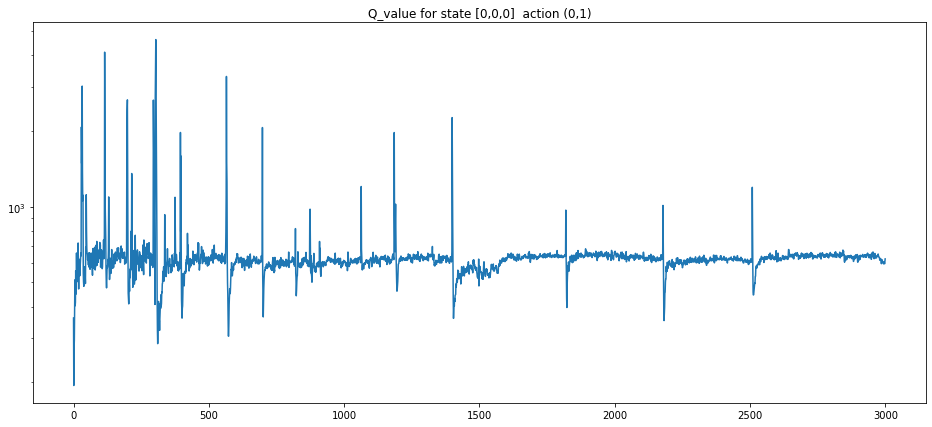

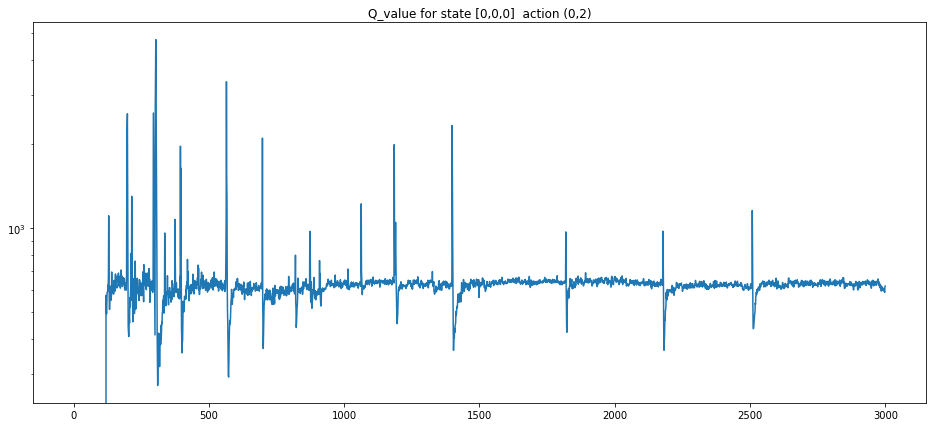

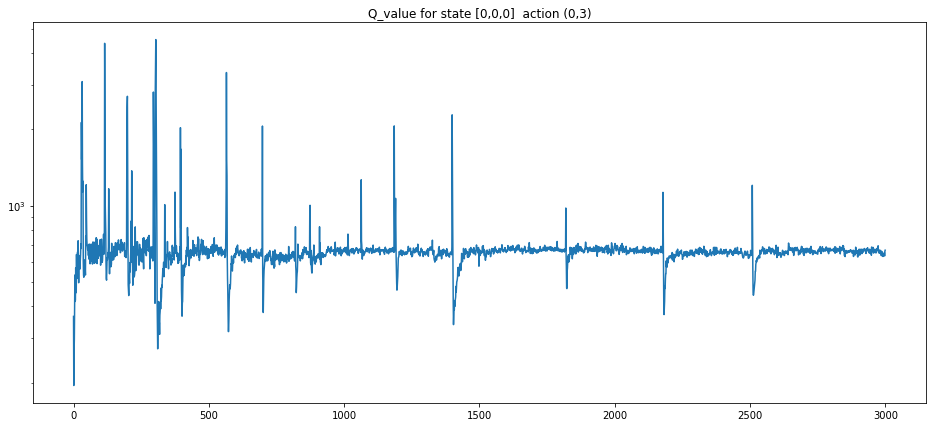

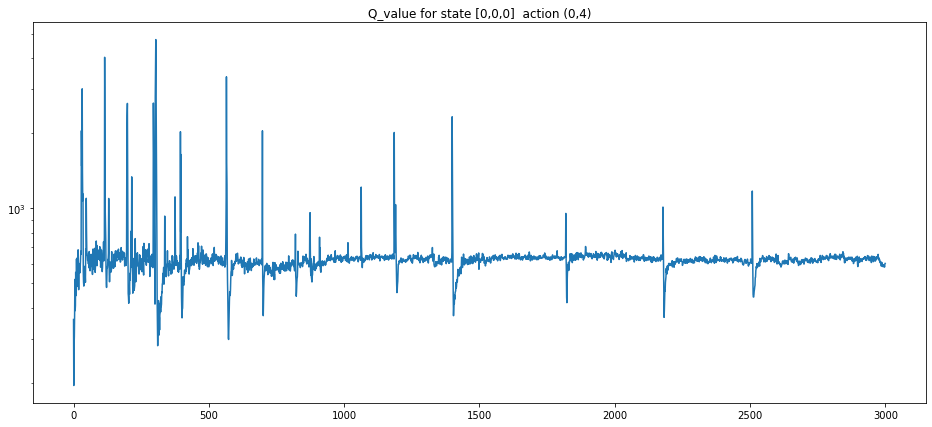

In [10]:
for i in range(1,5):
    plt.figure(0, figsize=(16,7))
    plt.title('Q_value for state [0,0,0]  action (0,'+ str(i) +')')
    xaxis = np.asarray(range(0, len(agent.states_tracked[i-1])))
    plt.semilogy(xaxis,np.asarray(agent.states_tracked[i-1]))
    plt.show()

# 6. Track rewards per episode

In [11]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

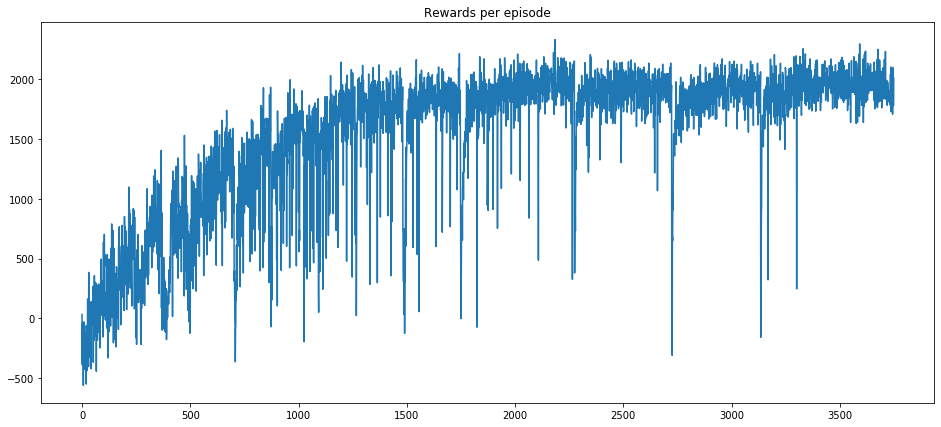

In [12]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
 Try building a similar epsilon-decay function for your model.
</div>

In [13]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

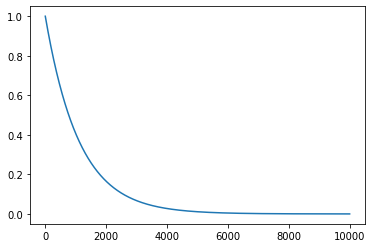

In [14]:
plt.plot(time, epsilon)
plt.show()